In [1]:
import os
import tensorflow as tf
from tensorflow import keras
import keras.backend as K

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

/Users/jgonda/.pyenv/versions/3.7.0/envs/tf-3.7.0/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
Using TensorFlow backend.


In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
def multivariate_data(dataset, target, start_index, end_index, history_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset)

  for i in range(start_index, end_index):
    indices = range(i - history_size, i)
    data.append(dataset[indices])
    labels.append(target[i])

  return np.array(data), np.array(labels)

In [4]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision + recall + K.epsilon())
    return f1_val

In [5]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'], color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'], color=colors[n], label='Val '+label, linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

In [6]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [7]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Non Signal Detected (True Negatives): ', cm[0][0])
  print('Signal Incorrectly Detected (False Positives): ', cm[0][1])
  print('Non Signal Missed (False Negatives): ', cm[1][0])
  print('Signal Detected (True Positives): ', cm[1][1])
  print('Total Signals: ', np.sum(cm[1]))

Params

In [8]:
rnd_state = 123456
history = 24
total_sample = 0

tf.random.set_seed(rnd_state)

In [9]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    f1_score
]

EPOCHS = 100
BATCH_SIZE = 256

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

Reading and transforming data

In [10]:
X_train = X_test = y_train = y_test = np.array([])

for root, subdirs, files in os.walk("data/pairs/EURUSD"):
    for f in files:
        pair = root[-6:]
        print(root, f)
        raw_df = pd.read_csv(root + "/" + f, index_col="date")
        
        neg, pos = np.bincount(raw_df["signal"])
        total = neg + pos
        print("{}:\nTotal: {}\nPositive: {} ({:.2f}% of total)\n".format(pair, total, pos, 100 * pos / total))
        
        #split for RNN
        cols = raw_df[raw_df.columns[:-1]].to_numpy()
        label = raw_df[raw_df.columns[-1]].to_numpy()
        X, y = multivariate_data(cols, label, 0, len(raw_df), history)
        
        #Balancing
        pos_features = X[np.where(y == True)[0]]
        neg_features = X[np.where(y == False)[0]]

        pos_labels = y[np.where(y == True)[0]]
        neg_labels = y[np.where(y == False)[0]]
        
        ids = np.arange(len(pos_features))
        choices = np.random.choice(ids, len(neg_features)) # Generates a random sample from a given array
        resampled_pos_features = pos_features[choices]
        resampled_pos_labels = pos_labels[choices]
        
        resampled_features = np.concatenate([resampled_pos_features, neg_features], axis=0)
        resampled_labels = np.concatenate([resampled_pos_labels, neg_labels], axis=0)
        
        order = np.arange(len(resampled_labels))
        np.random.shuffle(order)
        resampled_features = resampled_features[order]
        resampled_labels = resampled_labels[order]
        
        neg, pos = np.bincount(resampled_labels)
        total = neg + pos
        print("After resampling:\nTotal: {}\nPositive: {} ({:.2f}% of total)\n".format(total, pos, 100 * pos / total))
        total_sample += total

        #Spliting
        p_X_train, p_X_test, p_y_train, p_y_test = train_test_split(resampled_features, resampled_labels, test_size=0.30, random_state=rnd_state)
        
        #Scaling
        shape_train = p_X_train.shape
        shape_test = p_X_test.shape
        scaler = StandardScaler()
        
        scaled_X_train = scaler.fit_transform(p_X_train.reshape(shape_train[0]*shape_train[1], shape_train[2])).reshape(shape_train)
        p_X_test = scaler.transform(p_X_test.reshape(shape_test[0]*shape_test[1], shape_test[2])).reshape(shape_test)
        
        #Noising
        
        if len(X_train):
            X_train = np.concatenate([X_train, p_X_train], axis=0)
            X_test = np.concatenate([X_test, p_X_test], axis=0)
            y_train = np.concatenate([y_train, p_y_train], axis=0)
            y_test = np.concatenate([y_test, p_y_test], axis=0)
        else:
            X_train, X_test, y_train, y_test = p_X_train, p_X_test, p_y_train, p_y_test

data/pairs/EURUSD H1.csv
EURUSD:
Total: 8088
Positive: 57 (0.70% of total)

After resampling:
Total: 16014
Positive: 8007 (50.00% of total)



Setting input shape

In [11]:
input_shape = (X_train.shape[1], X_train.shape[2])

In [12]:
total_sample

16014

In [13]:
X_train.shape

(11209, 24, 11)

In [14]:
raw_df

,Open,High,Low,Close,ema_8,ema_21,ema_50,ema_200,macd,macd_signal,macd_hist,signal
date,,,,,,,,,,,,
2019-01-02 05:00:00,1.144662,1.147905,1.144662,1.146470,1.144976,1.144510,1.143844,1.141083,0.000347,0.000176,0.000171,False
2019-01-02 06:00:00,1.145566,1.149690,1.145566,1.148444,1.145747,1.144867,1.144025,1.141156,0.000615,0.000263,0.000352,False
2019-01-02 07:00:00,1.147005,1.149330,1.147005,1.148236,1.146300,1.145174,1.144190,1.141227,0.000802,0.000371,0.000431,False
2019-01-02 08:00:00,1.147621,1.147820,1.142885,1.145801,1.146189,1.145231,1.144253,1.141272,0.000745,0.000446,0.000299,False
2019-01-02 09:00:00,1.146711,1.146711,1.142220,1.143863,1.145672,1.145106,1.144238,1.141298,0.000537,0.000464,0.000073,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-12 22:00:00,1.094454,1.094454,1.093280,1.093885,1.094200,1.093865,1.092137,1.089979,0.000570,0.000772,-0.000202,False
2020-04-12 23:00:00,1.094169,1.094169,1.093060,1.093408,1.094024,1.093823,1.092187,1.090013,0.000467,0.000711,-0.000244,False
2020-04-13 00:00:00,1.093788,1.093830,1.092855,1.093217,1.093845,1.093768,1.092227,1.090045,0.000366,0.000642,-0.000276,False


In [15]:
def model_v1(input_shape, metrics):

    inputs = keras.layers.Input(shape=input_shape)
    output_1 = keras.layers.LSTM(units=128, activation="relu")(inputs)
    output_2 = keras.layers.Dropout(0.5)(output_1)
    prediction = keras.layers.Dense(units=1, activation="sigmoid")(output_2)
    model = keras.models.Model(inputs=inputs, outputs=prediction)
    model.compile(
        optimizer=keras.optimizers.RMSprop(lr=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )
    return model

In [16]:
def model_v2(input_shape, metrics):

    inputs = keras.layers.Input(shape=input_shape)
    output_1 = keras.layers.Bidirectional(keras.layers.LSTM(units=128, activation="relu"))(inputs)
    output_2 = keras.layers.Dropout(0.5)(output_1)
    prediction = keras.layers.Dense(units=1, activation="sigmoid")(output_2)
    model = keras.models.Model(inputs=inputs, outputs=prediction)
    model.compile(
        optimizer=keras.optimizers.RMSprop(lr=1e-5),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )
    return model

In [17]:
def model_v3(input_shape, metrics):

    inputs = keras.layers.Input(shape=input_shape)
    output_1 = keras.layers.LSTM(units=256, return_sequences=True, activation="relu")(inputs)
    output_2 = keras.layers.LSTM(units=128, return_sequences=True, activation="relu")(output_1)
    output_3 = keras.layers.LSTM(units=64, activation="relu")(output_2)
    output_4 = keras.layers.Dropout(0.5)(output_3)
    prediction = keras.layers.Dense(units=1, activation="sigmoid")(output_4)
    model = keras.models.Model(inputs=inputs, outputs=prediction)
    model.compile(
        optimizer=keras.optimizers.RMSprop(lr=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )
    return model

In [18]:
def model_v4(input_shape, metrics):

    inputs = keras.layers.Input(shape=input_shape)
    output_1 = keras.layers.Bidirectional(keras.layers.LSTM(units=256, return_sequences=True, activation="relu"))(inputs)
    output_2 = keras.layers.Bidirectional(keras.layers.LSTM(units=128, return_sequences=True, activation="relu"))(output_1)
    output_3 = keras.layers.Bidirectional(keras.layers.LSTM(units=64, activation="relu"))(output_2)
    output_4 = keras.layers.Dropout(0.5)(output_3)
    prediction = keras.layers.Dense(units=1, activation="sigmoid")(output_4)
    model = keras.models.Model(inputs=inputs, outputs=prediction)
    model.compile(
        optimizer=keras.optimizers.RMSprop(lr=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )
    return model

In [19]:
model = model_v1(input_shape, METRICS)
model_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    #steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=(X_test, y_test),
    verbose=1)

Train on 11209 samples, validate on 4805 samples
Epoch 1/100
11209/11209 [==============================] - 4s 367us/sample - loss: 0.6960 - tp: 2846.0000 - fp: 2916.0000 - tn: 2685.0000 - fn: 2762.0000 - accuracy: 0.4934 - precision: 0.4939 - recall: 0.5075 - auc: 0.4960 - f1_score: 0.4754 - val_loss: 0.6942 - val_tp: 1849.0000 - val_fp: 1830.0000 - val_tn: 576.0000 - val_fn: 550.0000 - val_accuracy: 0.5047 - val_precision: 0.5026 - val_recall: 0.7707 - val_auc: 0.4932 - val_f1_score: 0.6081
Epoch 2/100
11209/11209 [==============================] - 2s 146us/sample - loss: 0.6942 - tp: 2659.0000 - fp: 2642.0000 - tn: 2959.0000 - fn: 2949.0000 - accuracy: 0.5012 - precision: 0.5016 - recall: 0.4741 - auc: 0.4987 - f1_score: 0.4536 - val_loss: 0.6936 - val_tp: 1879.0000 - val_fp: 1738.0000 - val_tn: 668.0000 - val_fn: 520.0000 - val_accuracy: 0.5301 - val_precision: 0.5195 - val_recall: 0.7832 - val_auc: 0.5121 - val_f1_score: 0.6244
Epoch 3/100
11209/11209 [============================

11209/11209 [==============================] - 2s 152us/sample - loss: 0.6933 - tp: 2615.0000 - fp: 2632.0000 - tn: 2969.0000 - fn: 2993.0000 - accuracy: 0.4982 - precision: 0.4984 - recall: 0.4663 - auc: 0.4979 - f1_score: 0.4428 - val_loss: 0.6995 - val_tp: 1681.0000 - val_fp: 1433.0000 - val_tn: 973.0000 - val_fn: 718.0000 - val_accuracy: 0.5523 - val_precision: 0.5398 - val_recall: 0.7007 - val_auc: 0.5276 - val_f1_score: 0.6096
Epoch 20/100
11209/11209 [==============================] - 2s 156us/sample - loss: 0.6933 - tp: 2423.0000 - fp: 2456.0000 - tn: 3145.0000 - fn: 3185.0000 - accuracy: 0.4967 - precision: 0.4966 - recall: 0.4321 - auc: 0.4993 - f1_score: 0.4402 - val_loss: 0.6991 - val_tp: 1681.0000 - val_fp: 1431.0000 - val_tn: 975.0000 - val_fn: 718.0000 - val_accuracy: 0.5528 - val_precision: 0.5402 - val_recall: 0.7007 - val_auc: 0.5270 - val_f1_score: 0.6098
Epoch 21/100
11209/11209 [==============================] - 2s 156us/sample - loss: 0.6933 - tp: 3178.0000 - fp: 

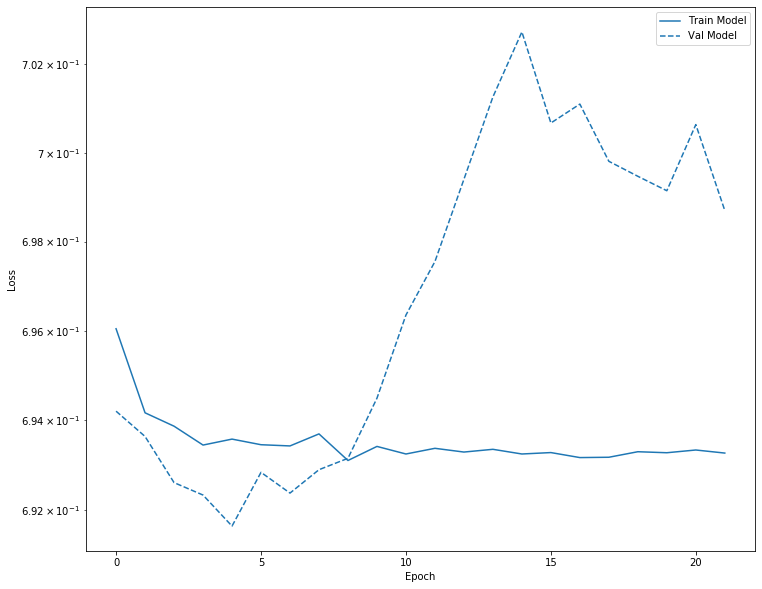

In [20]:
plot_loss(model_history, "Model", 0)

In [23]:
model_baseline = model.predict(X_test)

Non Signal Detected (True Negatives):  1001
Signal Incorrectly Detected (False Positives):  1405
Non Signal Missed (False Negatives):  799
Signal Detected (True Positives):  1600
Total Signals:  2399


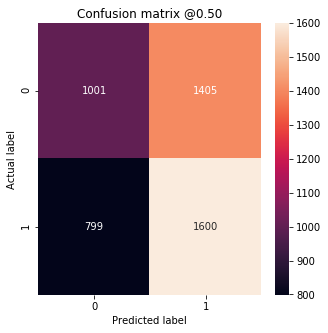

In [24]:
plot_cm(y_test, model_baseline, 0.5)

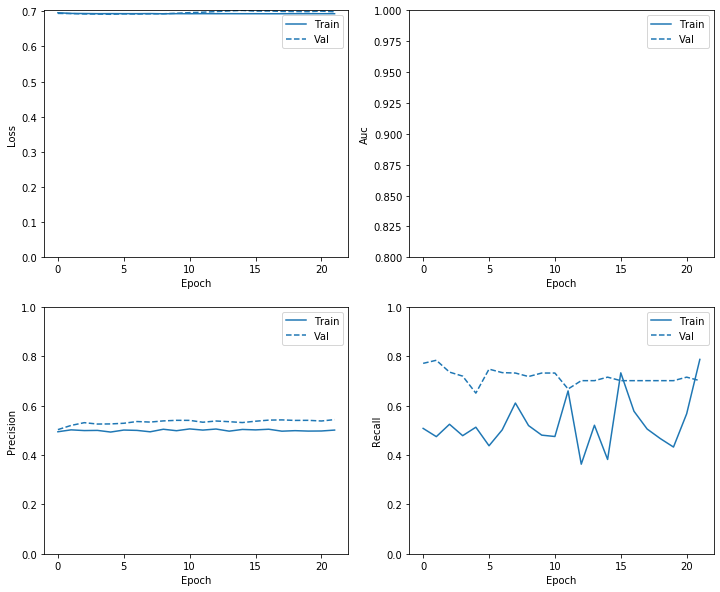

In [25]:
plot_metrics(model_history )